# Learning Probability Density Functions using data only
Naman Singh | 102317144

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')

print(torch.__version__)
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

2.9.0+cu128
GPU: Tesla T4


In [2]:
# my roll no se params nikalo
r = 102317144
a_r = 0.5 * (r % 7)
b_r = 0.3 * (r % 5 + 1)

print(f"Roll: {r}")
print(f"a_r = {a_r}")
print(f"b_r = {b_r}")
print(f"Transform: z = x + {a_r}*sin({b_r}*x)")

Roll: 102317144
a_r = 3.0
b_r = 1.5
Transform: z = x + 3.0*sin(1.5*x)


In [3]:
# load NO2 data
try:
    df = pd.read_csv('/content/data.csv', encoding='latin-1', low_memory=False)
except:
    print("Error loading file")

no2_vals = df['no2'].dropna().values

# random subset lelo speed ke liye
np.random.seed(42)
total = len(no2_vals)
n_samp = 50000
indices = np.random.choice(total, n_samp, replace=False)
x = no2_vals[indices]

print(f"Total samples: {total}")
print(f"Using: {len(x)}")
print(f"Range: {x.min():.1f} to {x.max():.1f}")

Total samples: 419509
Using: 50000
Range: 0.0 to 377.0


In [4]:
# transformation apply karo
z = x + a_r * np.sin(b_r * x)
print(f"z range: {z.min():.1f} to {z.max():.1f}")

z range: 0.0 to 377.0


In [5]:
# disc first
class Disc(nn.Module):
    def __init__(self):
        super(Disc, self).__init__()
        self.l1 = nn.Linear(1, 128)
        self.l2 = nn.Linear(128, 64)
        self.l3 = nn.Linear(64, 1)
        self.drop = nn.Dropout(0.3)

    def forward(self, x):
        h = torch.nn.functional.leaky_relu(self.l1(x), 0.2)
        h = self.drop(h)
        h = torch.nn.functional.leaky_relu(self.l2(h), 0.2)
        h = self.drop(h)
        out = torch.sigmoid(self.l3(h))
        return out

# gen network
class Gen(nn.Module):
    def __init__(self):
        super(Gen, self).__init__()
        self.fc1 = nn.Linear(100, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, noise):
        x = torch.nn.functional.leaky_relu(self.bn1(self.fc1(noise)), 0.2)
        x = torch.nn.functional.leaky_relu(self.bn2(self.fc2(x)), 0.2)
        return self.fc3(x)

print("models done")

models done


In [6]:
# training setup
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"using: {dev}")

if dev == 'cpu':
    print("WARNING: GPU not on!")

# data normalize
m = z.mean()
s = z.std()
z_norm = (z - m) / s

# dataloader banao
bs = 256
data_t = torch.FloatTensor(z_norm.reshape(-1, 1))
data_t = data_t.to(dev)
dataset = TensorDataset(data_t)
loader = DataLoader(dataset, batch_size=bs, shuffle=True)

# init
G = Gen().to(dev)
D = Disc().to(dev)

# loss
loss_func = nn.BCELoss()

# opts
opt_g = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_d = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

print(f"batch: {bs}")

using: cuda
batch: 256


In [7]:
# train karo
epochs = 1000
g_losses = []
d_losses = []

print(f"training {epochs} epochs...\n")

for ep in range(epochs):
    for batch, in loader:
        curr_bs = batch.size(0)

        # disc train
        opt_d.zero_grad()

        # real
        real_lbl = torch.ones(curr_bs, 1).to(dev)
        pred_r = D(batch)
        loss_r = loss_func(pred_r, real_lbl)

        # fake
        fake_lbl = torch.zeros(curr_bs, 1).to(dev)
        noise = torch.randn(curr_bs, 100).to(dev)
        fake = G(noise)
        pred_f = D(fake.detach())
        loss_f = loss_func(pred_f, fake_lbl)

        d_loss = loss_r + loss_f
        d_loss.backward()
        opt_d.step()

        # gen train
        opt_g.zero_grad()

        noise = torch.randn(curr_bs, 100).to(dev)
        fake = G(noise)
        pred = D(fake)
        g_loss = loss_func(pred, real_lbl)

        g_loss.backward()
        opt_g.step()

    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    if (ep + 1) % 200 == 0:
        print(f"Epoch {ep+1}/{epochs} - D: {d_loss.item():.4f}, G: {g_loss.item():.4f}")
        # print(f"real: {pred_r.mean().item():.3f}, fake: {pred_f.mean().item():.3f}")

print("done")

training 1000 epochs...

Epoch 200/1000 - D: 1.3850, G: 0.6932
Epoch 400/1000 - D: 1.3812, G: 0.6940
Epoch 600/1000 - D: 1.3854, G: 0.6925
Epoch 800/1000 - D: 1.3868, G: 0.6927
Epoch 1000/1000 - D: 1.3859, G: 0.6930
done


In [8]:
# samples generate
G.eval()
n = 50000

with torch.no_grad():
    noise = torch.randn(n, 100).to(dev)
    gen_out = G(noise).cpu().numpy()

# denorm
z_gen = gen_out.flatten()
z_gen = z_gen * s + m

print(f"generated {n} samples")
print(f"range: {z_gen.min():.1f} to {z_gen.max():.1f}")

generated 50000 samples
range: 3.3 to 196.6


In [9]:
# PDF estimate
kde = gaussian_kde(z_gen)
grid = np.linspace(z_gen.min(), z_gen.max(), 1000)
pdf = kde(grid)

print("PDF done")

PDF done


saved results.png


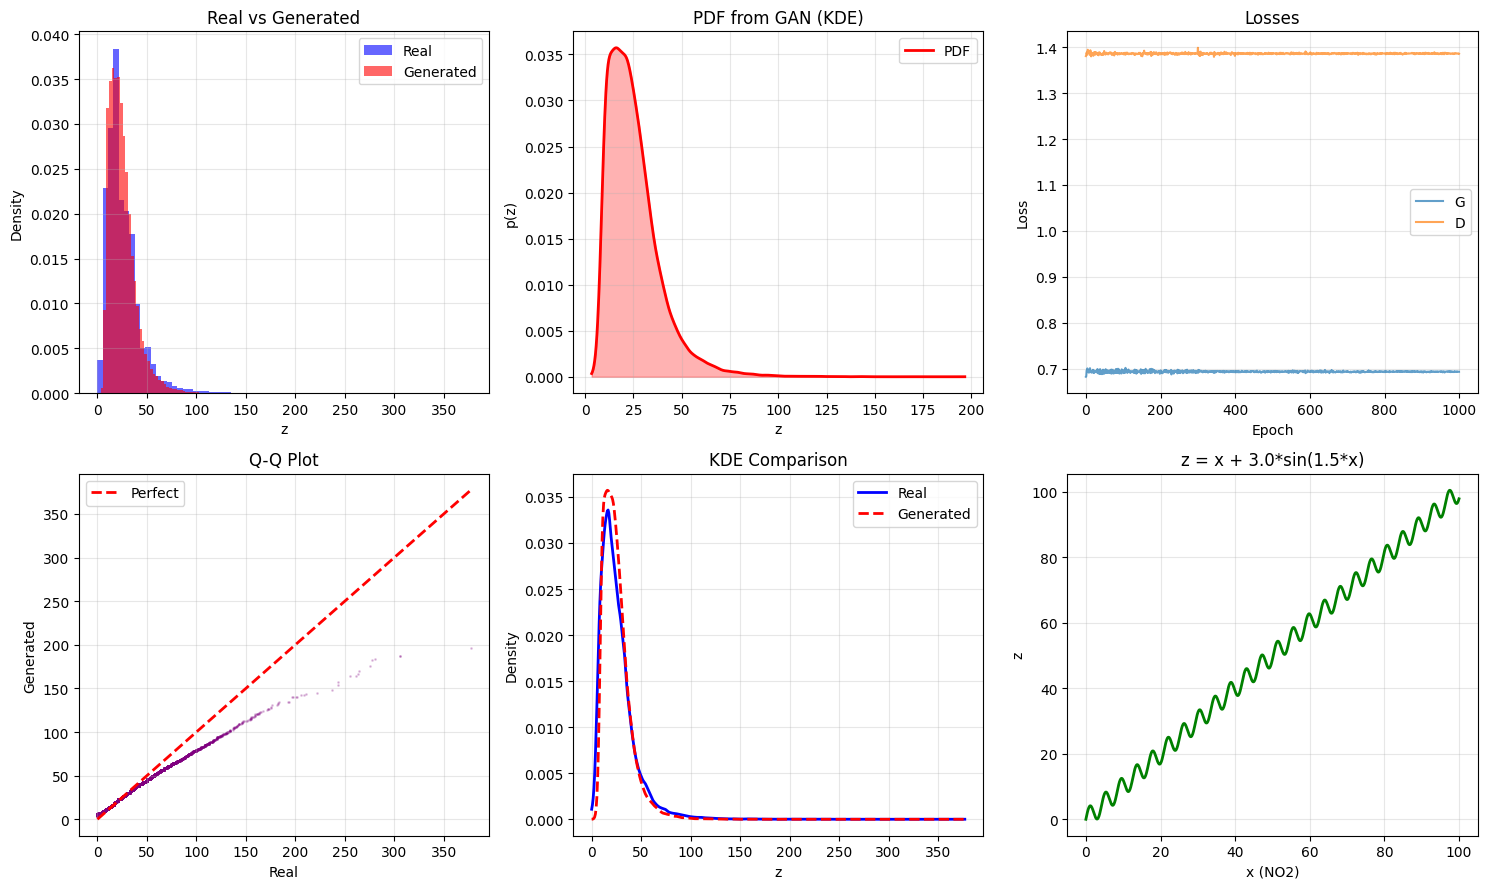

In [10]:
# plots banao
fig = plt.figure(figsize=(15, 9))

# hist
plt.subplot(2, 3, 1)
plt.hist(z, bins=70, alpha=0.6, label='Real', color='blue', density=True)
plt.hist(z_gen, bins=70, alpha=0.6, label='Generated', color='red', density=True)
plt.xlabel('z')
plt.ylabel('Density')
plt.title('Real vs Generated')
plt.legend()
plt.grid(alpha=0.3)

# PDF
plt.subplot(2, 3, 2)
plt.plot(grid, pdf, 'r-', linewidth=2, label='PDF')
plt.fill_between(grid, pdf, alpha=0.3, color='red')
plt.xlabel('z')
plt.ylabel('p(z)')
plt.title('PDF from GAN (KDE)')
plt.legend()
plt.grid(alpha=0.3)

# losses
plt.subplot(2, 3, 3)
plt.plot(g_losses, alpha=0.7, label='G')
plt.plot(d_losses, alpha=0.7, label='D')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses')
plt.legend()
plt.grid(alpha=0.3)

# Q-Q
plt.subplot(2, 3, 4)
n_qq = len(z) if len(z) < len(z_gen) else len(z_gen)
z_sort = np.sort(z[:n_qq])
gen_sort = np.sort(z_gen[:n_qq])
plt.scatter(z_sort, gen_sort, alpha=0.2, s=1, color='purple')
plt.plot([z_sort.min(), z_sort.max()], [z_sort.min(), z_sort.max()], 'r--', lw=2, label='Perfect')
plt.xlabel('Real')
plt.ylabel('Generated')
plt.title('Q-Q Plot')
plt.legend()
plt.grid(alpha=0.3)

# KDE comp
plt.subplot(2, 3, 5)
kde_r = gaussian_kde(z)
kde_g = gaussian_kde(z_gen)
x_min = z.min() if z.min() < z_gen.min() else z_gen.min()
x_max = z.max() if z.max() > z_gen.max() else z_gen.max()
x_rng = np.linspace(x_min, x_max, 500)
plt.plot(x_rng, kde_r(x_rng), 'b-', label='Real', linewidth=2)
plt.plot(x_rng, kde_g(x_rng), 'r--', label='Generated', linewidth=2)
plt.xlabel('z')
plt.ylabel('Density')
plt.title('KDE Comparison')
plt.legend()
plt.grid(alpha=0.3)

# transform
plt.subplot(2, 3, 6)
x_plot = np.linspace(0, 100, 1000)
z_plot = x_plot + a_r * np.sin(b_r * x_plot)
plt.plot(x_plot, z_plot, 'g-', linewidth=2)
plt.xlabel('x (NO2)')
plt.ylabel('z')
plt.title(f'z = x + {a_r}*sin({b_r}*x)')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('results.png', dpi=300, bbox_inches='tight')
print("saved results.png")
plt.show()

In [11]:
# stats check karo
print("Stats:")
print(f"Real - mean: {z.mean():.2f}, std: {z.std():.2f}")
print(f"Gen  - mean: {z_gen.mean():.2f}, std: {z_gen.std():.2f}")
diff = abs(z.mean() - z_gen.mean())
print(f"Diff: {diff:.2f}")

Stats:
Real - mean: 25.88, std: 18.03
Gen  - mean: 25.30, std: 13.94
Diff: 0.58
